## Policy Note

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [13]:
def process_country_data(country_code):
    # Load Excel files into DataFrames
    dc = pd.read_excel(f"deficitcomptable.{country_code}.xlsx", index_col='period')
    pb = pd.read_excel(f"ProdBrut.{country_code}.xlsx", index_col='period')
    inn = pd.read_excel(f"interest.{country_code}.xlsx", index_col='period')
    PIB = pd.read_excel("PIB.xlsx")

    # Process index for each DataFrame
    dc.index = pd.to_datetime(dc.index, format='%Y')
    pb.index = pd.PeriodIndex(pb.index, freq='Q').to_timestamp()
    inn.index = pd.to_datetime(inn.index, format='%Y')

    # Sum the data annually
    pb = pb.resample('A').sum()

    # Adjust indexes to be year only
    pb.index = pb.index.year
    dc.index = dc.index.year
    inn.index = inn.index.year

    # Filter and process PIB data
    PIB = PIB[PIB['country'] == country_code]
    PIB.index = PIB['year']
    PIB = PIB[['debtgdp']]

    # Merge DataFrames by year index
    df = pd.merge(pb, dc, left_index=True, right_index=True)
    df = pd.merge(df, PIB, left_index=True, right_index=True)
    df = pd.merge(df, inn, left_index=True, right_index=True)

    # Rename columns
    df.columns = ['Produit intérieur brut', 'Capacité (+) ou besoin (-)', 'debtgdp', 'interest']

    # Adjust units
    df['Produit intérieur brut'] = df['Produit intérieur brut'] / 1000
    df['Capacité (+) ou besoin (-)'] = df['Capacité (+) ou besoin (-)'] / 1000
    df['interest'] = df['interest'] / 1000

    # Calculate additional metrics
    df['dette'] = df['debtgdp'] * df['Produit intérieur brut']
    df['variation dette'] = df['dette'].diff()
    df['adjust flux'] = df['variation dette'] - (df['Capacité (+) ou besoin (-)'] * -1)
    df['adjust flux sur PIB'] = (df['adjust flux'] / df['Produit intérieur brut']) * 100
    df['Deficit sur PIB'] = (df['Capacité (+) ou besoin (-)'] * -1 / df['Produit intérieur brut']) * 100
    df['plus ASF'] = (((df['Capacité (+) ou besoin (-)'] * -1 - df['interest']) / df['Produit intérieur brut']) * 100) + df['adjust flux sur PIB']

    # Calculate term r-g
    left = df['Produit intérieur brut'].pct_change() * df['dette'] / df['Produit intérieur brut']
    right = df['interest'] / df['Produit intérieur brut']
    df['term r-g'] = (right - left) * 100

    return df



In [14]:
def plot_data(df, country_code):
    # RED BLUE GRAPH
    colors = ['blue', 'red']  # Colors for each stack
    ax = df[['adjust flux sur PIB', 'Deficit sur PIB']].plot(kind='bar', stacked=True, color=colors)

    plt.legend(["adjustement stock flux", "défecit public"])

    # Set x-ticks to display every other year
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2], minor=False)
    ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_major_formatter(PercentFormatter(100.0))

    plt.title(f'Financial Data for {country_code}')
    plt.xlabel('Year')
    plt.ylabel('Percentage')

    # Save the plot
    plt.savefig(f'{country_code}_Fig1.png')
    plt.show()
    plt.close()

    # RED GREEN GRAPH
    colors = ['red', 'green']  # Red for 'plus ASF', Green for 'term r-g'
    ax = df[['plus ASF', 'term r-g']].plot(kind='bar', stacked=True, color=colors)

    plt.legend(["défecit primaire (plus ASF)", "terme r-g"])

    # Set x-ticks to display every other year
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2], minor=False)
    ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_major_formatter(PercentFormatter(100.0))

    plt.title(f'Financial Data for {country_code}')
    plt.xlabel('Year')
    plt.ylabel('Percentage')

    # Save the plot
    plt.savefig(f'{country_code}_Fig2.png')
    plt.show()  
    plt.close()


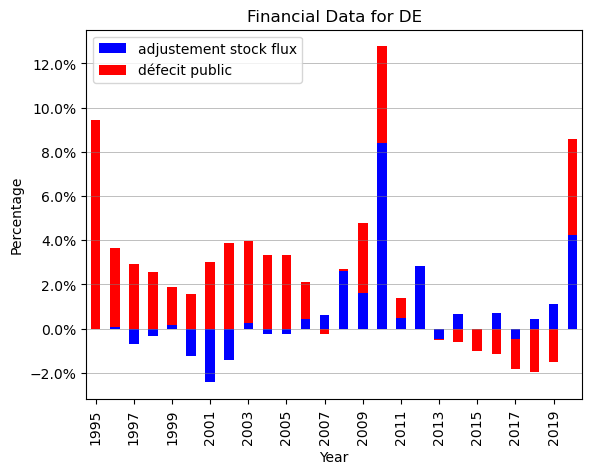

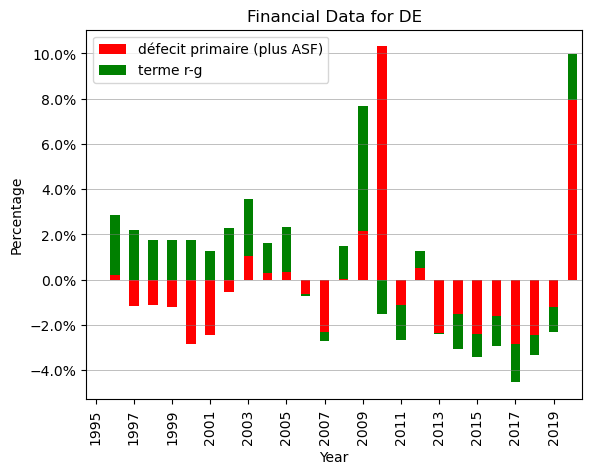

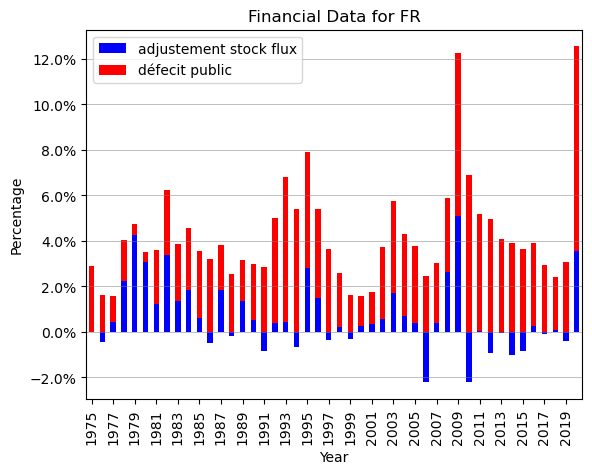

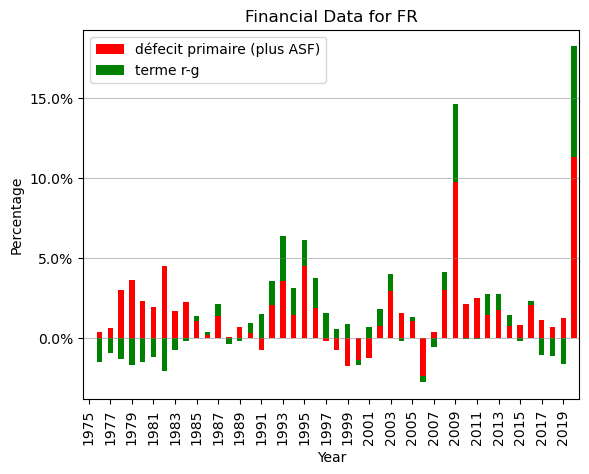

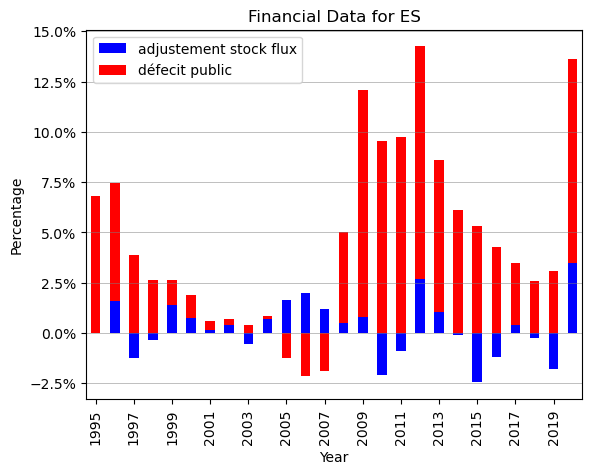

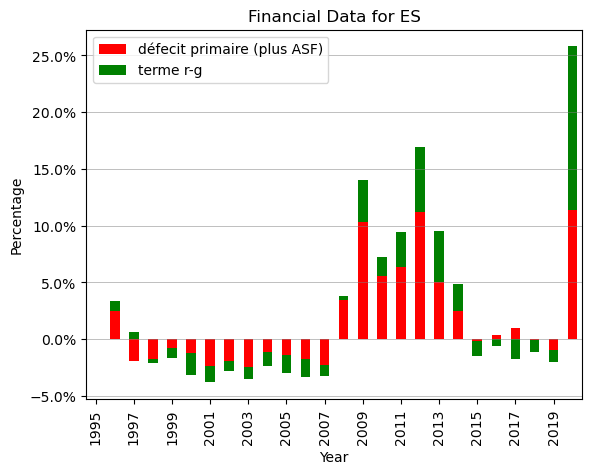

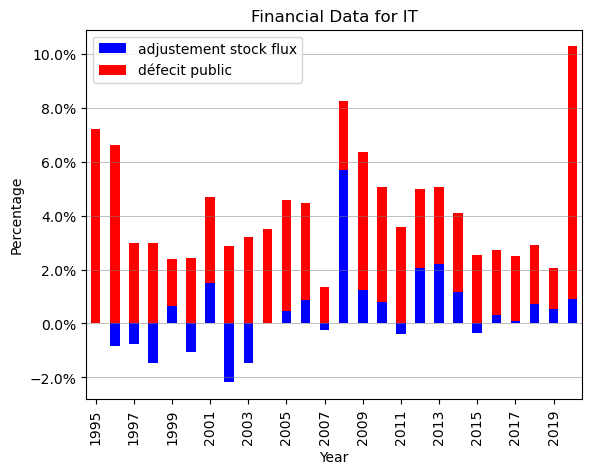

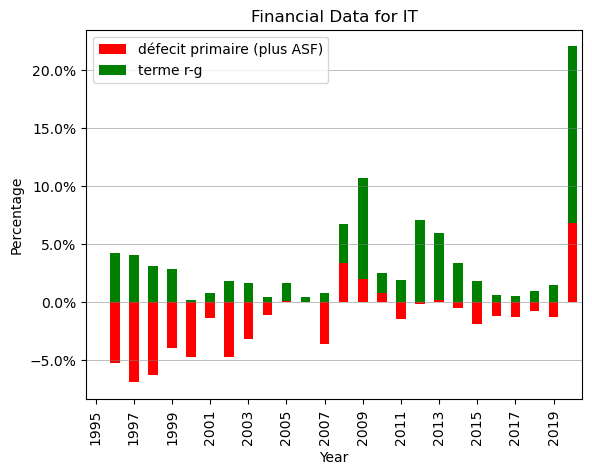

In [15]:
# List of country codes
countries = ['DE', 'FR', 'ES', 'IT']

# Process data and plot for each country
for country in countries:
    df = process_country_data(country)
    globals()[f'df_{country}'] = df  # Create DataFrame variable for each country
    plot_data(df, country)